# Vehicle Detection

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and append binned color feature and hisgram of color  to HOG feature vector.
* Train a  Linear SVM classifier.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Run the pipeline on a video stream (full project_video.mp4) and estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pprint

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV

import utilities
import vehicleDetection

%matplotlib inline

In [2]:
# Divide up into cars and notcars
images = glob.glob('data/*/*/*.png')
vehicles = []
notvehicles = []
for image in images:
    if 'non-vehicles' in image:
        notvehicles.append(image)
    elif 'vehicles' in image:
        vehicles.append(image)
    else:
        print("error")

In [3]:
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
ORIENT = 9
WINDOW_SCALE = 1.1
CHECK_FRAME_RANGE = 11
THRESHOLD = 1

# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier

In [4]:
# In addition to HOG feature, I used histgram of color and color feature

t=time.time()
car_features = utilities.extract_features(vehicles, orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)

notcar_features = utilities.extract_features(notvehicles, orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

164.12 Seconds to extract HOG features...


In [5]:
# Create the feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
np.random.seed(10)
rand_state = np.random.randint(0, 100) 
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',ORIENT,'orientations',PIX_PER_CELL, 'pixels per cell and', CELL_PER_BLOCK,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


#  Train a Linear SVM classifier

In [6]:
# Estimate best parameters

svc = LinearSVC()
parameters = [{
    'C' : [x/10 for x in list(range(2, 20, 2))],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

best parameter:{'C': 0.2, 'loss': 'hinge', 'penalty': 'l2'}
[('0.983108', '0.006882', {'C': 0.2, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.2, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.4, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.4, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.6, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.6, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.8, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.8, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 1.0, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 1.2, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 1.2, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.983108', '0

In [7]:
svc = LinearSVC()
parameters = [{
    'C' : [x/100 for x in list(range(1, 30, 3))],
    'loss': ['hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

best parameter:{'C': 0.01, 'loss': 'hinge', 'penalty': 'l2'}
[('0.983108', '0.006882', {'C': 0.01, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.04, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.07, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.13, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.16, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.19, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.22, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.25, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.28, 'loss': 'hinge', 'penalty': 'l2'})]


In [8]:
svc = LinearSVC()
parameters = [{
    'C' : [x/10000 for x in list(range(1, 10, 1))],
    'loss': ['hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

best parameter:{'C': 0.0003, 'loss': 'hinge', 'penalty': 'l2'}
[('0.980293', '0.008507', {'C': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980293', '0.008132', {'C': 0.0002, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.008142', {'C': 0.0003, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.981982', '0.008263', {'C': 0.0004, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.981982', '0.007243', {'C': 0.0005, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.981982', '0.007243', {'C': 0.0006, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.982545', '0.006503', {'C': 0.0007, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.0008, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.983108', '0.006882', {'C': 0.0009, 'loss': 'hinge', 'penalty': 'l2'})]


In [9]:
# Train the LinearSVC classifier with best parameters

svc = LinearSVC(C=clf.best_params_['C'], loss=clf.best_params_['loss'], penalty=clf.best_params_['penalty'])

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

11.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
0.00549 Seconds to predict 10 labels with SVC


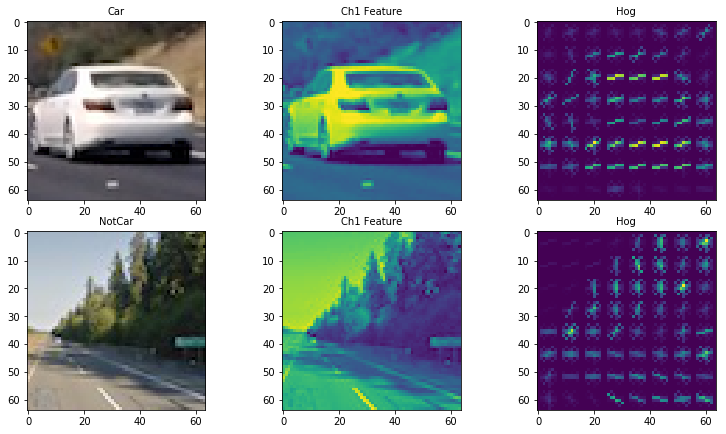

In [10]:
# Implement feature extrant and predict car or not using LinearSVM

testdata = {'Car': 'test_images/car2.png', 'Notcar': 'test_images/road.png'}

hog_imgs = []
Ych = []
for img in testdata.values():
    img = mpimg.imread(img)

    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    chf = feature_image[:,:,0]
    Ych.append(chf)
    feature, hog_img = utilities.get_hog_features(chf, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
    
    hog_imgs.append(hog_img)
    
fontsize = 10
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))
f.tight_layout()
ax1.imshow(mpimg.imread(testdata['Car']))
ax1.set_title('Car', fontsize=fontsize)
ax2.imshow(Ych[0])
ax2.set_title('Ch1 Feature', fontsize=fontsize)
ax3.imshow(hog_imgs[0])
ax3.set_title('Hog', fontsize=fontsize)

ax4.imshow(mpimg.imread(testdata['Notcar']))
ax4.set_title('NotCar', fontsize=fontsize)
ax5.imshow(Ych[1])
ax5.set_title('Ch1 Feature', fontsize=fontsize)
ax6.imshow(hog_imgs[1])
ax6.set_title('Hog', fontsize=fontsize)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# plt.savefig('get_hog_feature.png', bbox_inches="tight", dpi=200)

# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

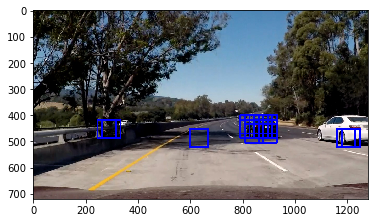

In [11]:
# Plot all windows
ystart = 400
ystop = 600
scale = 1.1

img = mpimg.imread('test_images/test5.jpg')

plotted_windows = utilities.window_search(img, ystart, ystop, scale, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, vis_window=True)

plt.imshow(plotted_windows)

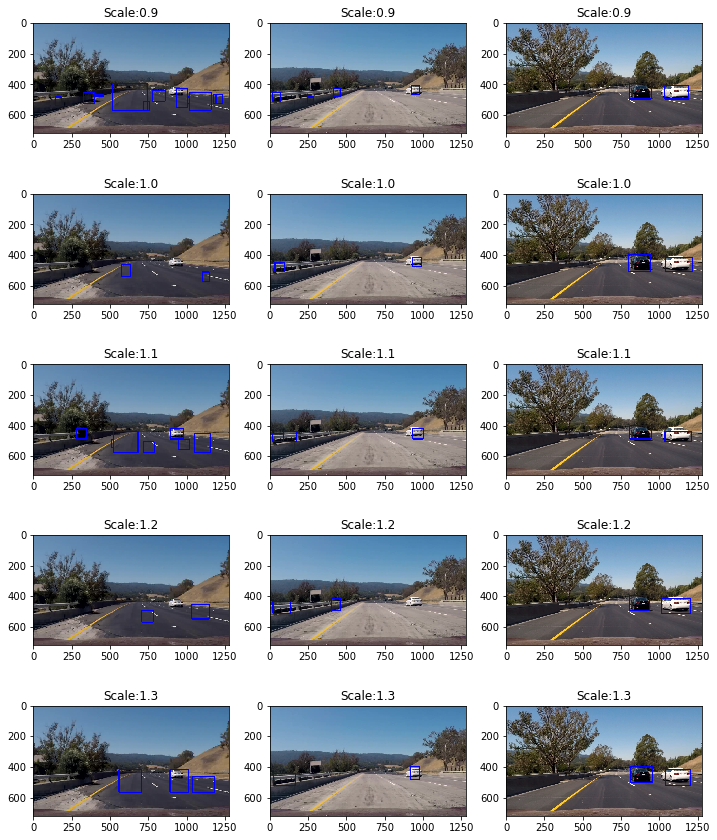

In [12]:
# Estimate image scale parameter used in utilities.window_search()

scales = [0.9, 1.0, 1.1, 1.2, 1.3]
index = 1

plt.figure(figsize=(10, 12))

for scale in scales:
    
    img0 = mpimg.imread('test_images/frame1_1.jpg')
    pipeline = vehicleDetection.Pipeline(svc, X_scaler, scale, CHECK_FRAME_RANGE, THRESHOLD, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)
    draw_img0 = pipeline(img0)
    
    plt.subplot(5, 3, index)
    plt.imshow(draw_img0)
    plt.title("Scale:{}".format(scale))
    
    img1 = mpimg.imread('test_images/frame1_2.jpg')
    pipeline = vehicleDetection.Pipeline(svc, X_scaler, scale, CHECK_FRAME_RANGE, THRESHOLD, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)
    draw_img1 = pipeline(img1)
    
    plt.subplot(5, 3, index+1)
    plt.imshow(draw_img1)
    plt.title("Scale:{}".format(scale))
    
    img2 = mpimg.imread('test_images/test6.jpg')
    pipeline2 = vehicleDetection.Pipeline(svc, X_scaler, scale, CHECK_FRAME_RANGE, THRESHOLD, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)
    draw_img2 = pipeline2(img2)

    plt.subplot(5, 3, index+2)
    plt.imshow(draw_img2)    
    plt.title("Scale:{}".format(scale))
    
    index = index+3

plt.tight_layout()
# plt.savefig('scale_seach.png', bbox_inches="tight", dpi=200)

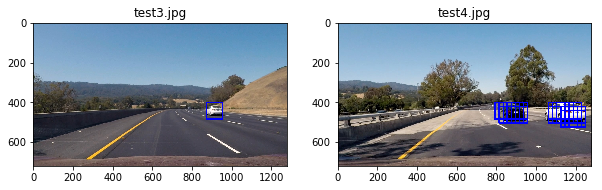

In [13]:
index = 1

plt.figure(figsize=(10, 7))

for input_fname in ['test_images/test3.jpg', 'test_images/test4.jpg']:
    img = mpimg.imread(input_fname)
    plotted_windows = utilities.window_search(img, 400, 600, scale, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, vis_window=True)

    plt.subplot(1, 2, index)
    plt.imshow(plotted_windows)
    plt.title(input_fname.split("/")[-1])
    
    index = index + 1
    
# plt.savefig('example_images.png', bbox_inches="tight", dpi=200)

# Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

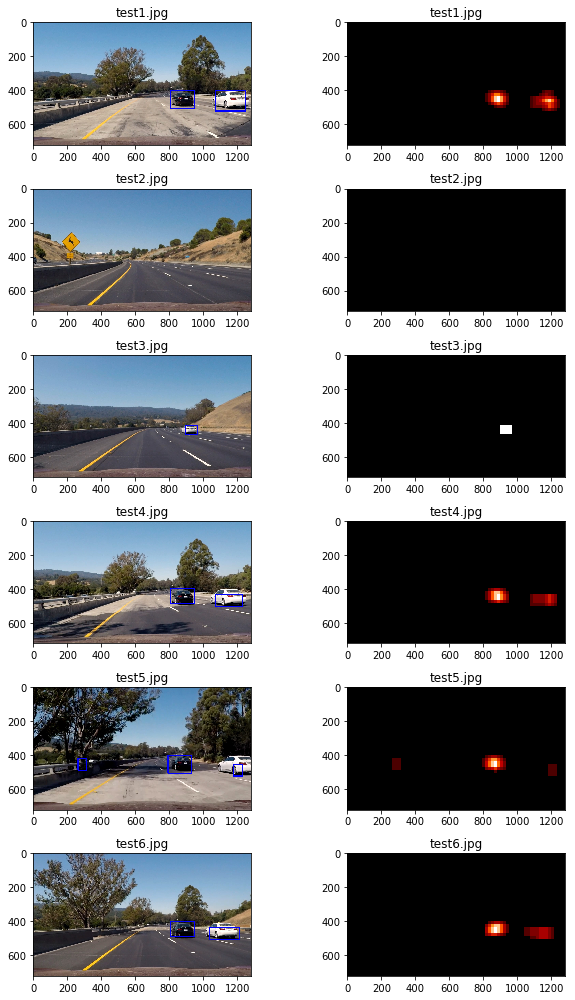

In [14]:
# Plot window detected car and heatmap
ystart = 400
ystop = 600
scale = 1.1

img_list = glob.glob('test_images/test*.jpg')

f, axarr = plt.subplots(6, 2, figsize=(9, 14))

for index, input_fname in enumerate(img_list): 
    image = mpimg.imread(input_fname)
    
    car_boxes = utilities.window_search(image, ystart, ystop, scale, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    heat = utilities.add_heat(heat, car_boxes)
    
    heat = utilities.apply_threshold(heat, THRESHOLD)
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = utilities.draw_labeled_bboxes(np.copy(image), labels)
 
    axarr[index, 0].imshow(draw_img)
    axarr[index, 0].set_title(input_fname.split("/")[-1])
    
    axarr[index, 1].imshow(heat, cmap=plt.cm.gist_heat)
    axarr[index, 1].set_title(input_fname.split("/")[-1])

plt.tight_layout()
# plt.savefig("heatmaps.png", bbox_inches="tight", dpi=200)

# Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
scale = 1.1
CHECK_FRAME_RANGE = 11

pipeline = vehicleDetection.Pipeline(svc, X_scaler, scale, CHECK_FRAME_RANGE, THRESHOLD, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)

In [17]:
white_output = 'result_project_video.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|█████████▉| 1260/1261 [16:36<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 

CPU times: user 24min 23s, sys: 30.6 s, total: 24min 53s
Wall time: 16min 38s
